In [4]:
import openpyxl

# wb = openpyxl.load_workbook("/Users/annamageras/Downloads/SAS ALL HIV+ Output.xlsx")
wb = openpyxl.load_workbook("/Volumes/Dropbox-Private/IeDEA/SAS KNOWS HIV BURUNDI 2011 Output.xlsx")

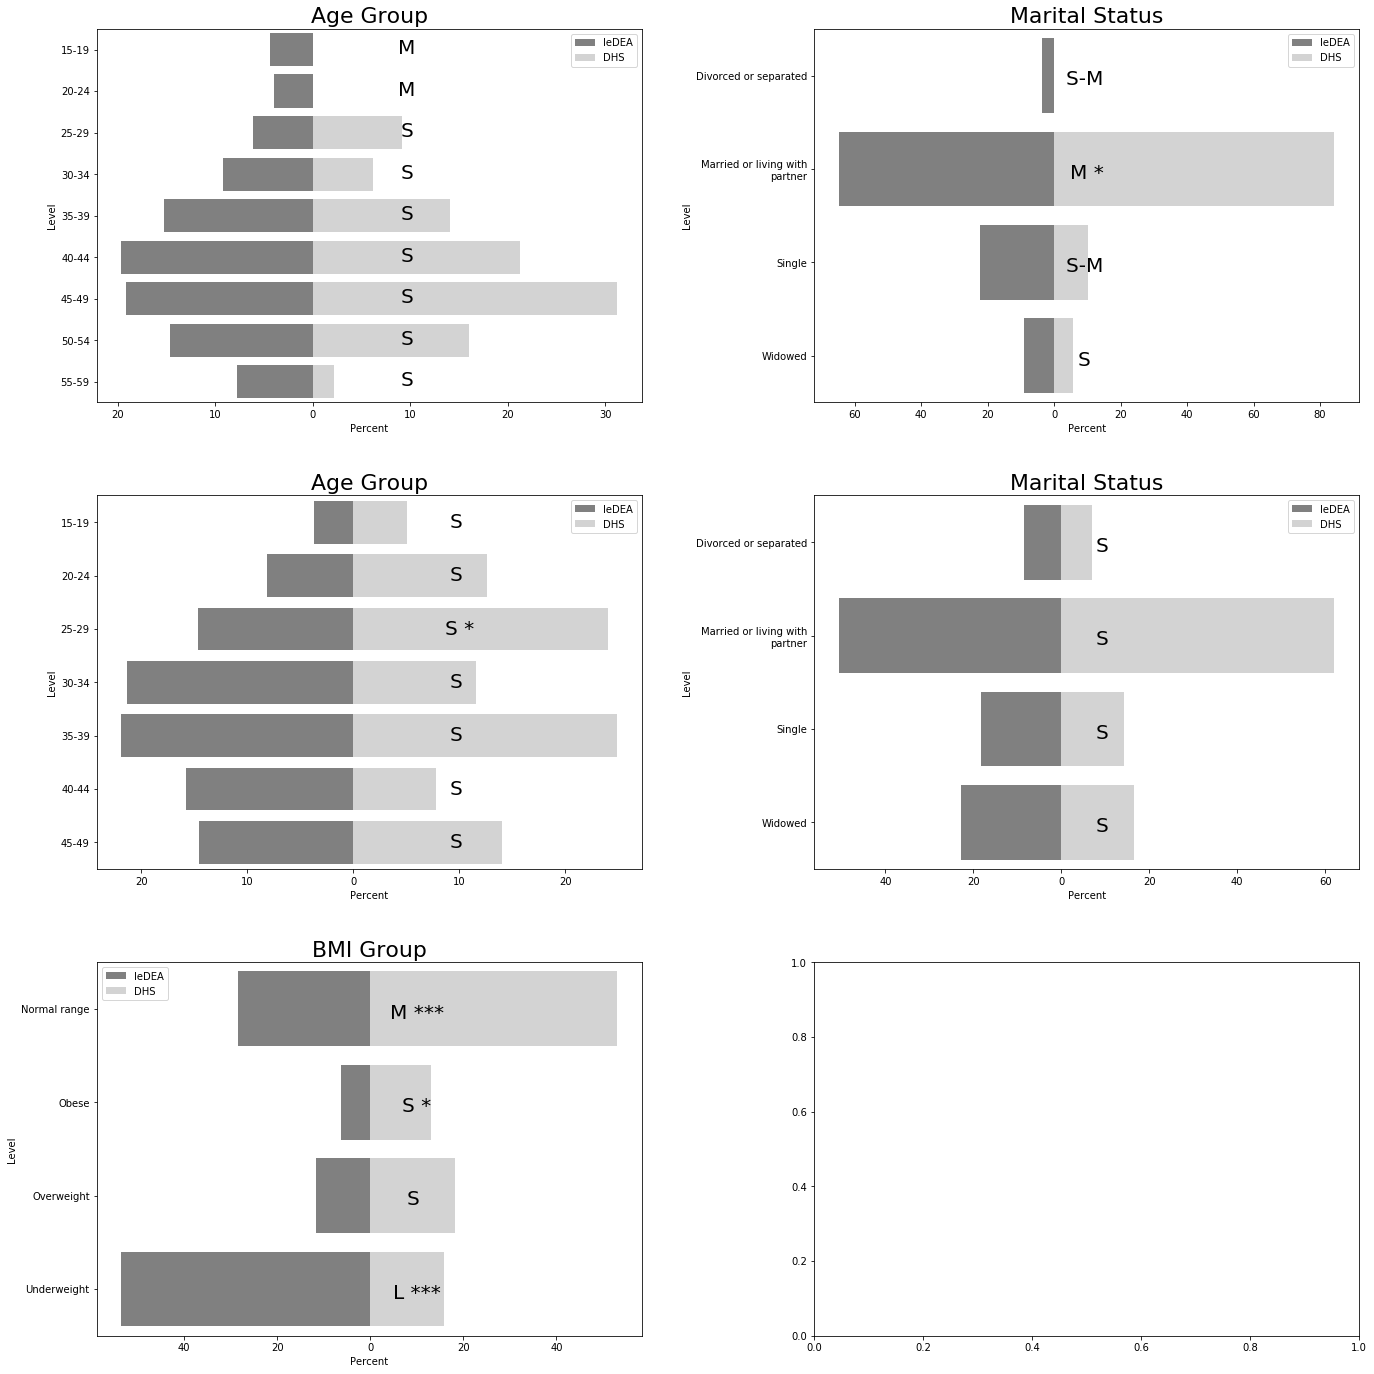

In [6]:
import itertools
import pandas as pd
import numpy as np
import re
from scipy.stats import t
from matplotlib.patches import Patch


DS = ["IeDEA", "DHS"]
INDEX = ["pregnant_controlling", "section_var_name", "section", "covariate"]

def crosstab_sheet_to_df(sheet, section_var_name="domain", controlling_for_aside_from_dataset=None):
    assert controlling_for_aside_from_dataset in ["pregnant", None], "currently can only control for pregnant"
    assert section_var_name == "domain", "TODO: refactor. This is conceptually simpler"
    out = []
    v = list(sheet.values)[2:]
    
    table_of = v[0][0]
    section_var_name, covariate = re.search("(\w+) by (\w+)", table_of).groups()
    controlling_for = v[1][0]
    m_dataset = re.search("dataset=([^ ]*)", controlling_for)
    dataset = m_dataset.groups()[0]
    m_pregnant_controlling = re.search("pregnant=(\w*)", controlling_for)
    pregnant_controlling = m_pregnant_controlling.groups()[0].strip() \
        if m_pregnant_controlling is not None else "N/A"
    df_raw = pd.DataFrame(v[3:], columns=v[2])
    section = None
    for idx, row in df_raw.iterrows():
        rd = row.to_dict()
        if rd[section_var_name]:
            section = rd[section_var_name]
        else:
            rd[section_var_name] = section
            
        out.append(pd.Series(rd))

    df_out = pd.DataFrame(out).rename(columns={section_var_name: "section"})
    df_out["covariate"] = covariate
    df_out["dataset"] = dataset
    df_out["pregnant_controlling"] = pregnant_controlling
    df_out["section_var_name"] = section_var_name
    return df_out.rename(columns={covariate: "level"})


def crosstab_df_clean(df_crosstab):
    Ns = {}
    for idx, row in df_crosstab.iterrows():
        if row["level"] == "Total":
            Ns[row["section"]] = row["Frequency"]

    df_out = pd.DataFrame(df_crosstab)
    df_out["N"] = df_crosstab.apply(
        lambda r: Ns[r["section"]], axis=1
    )
    return df_crosstab[["dataset"] + INDEX + ["level", "Row\nPercent", "N"]].rename(
        columns={"Row\nPercent": "Row_Percent"}
    ).replace(".", 0)



def wb_to_df(wb):
    dfs_clean = []
    for sn in wb.sheetnames:
        if "crosstab" in sn.lower():
            sheet = wb[sn]
            df_sheet = crosstab_sheet_to_df(sheet)
            df_sheet_clean = crosstab_df_clean(df_sheet)
            df_sheet_clean["sheet_name"] = sn
            dfs_clean.append(df_sheet_clean)
        
    dfc = pd.concat(dfs_clean)
    
    
    # filters - special cases where data is bad
    dfc = dfc[dfc.section != "Total"]
    filters = [
#       # missing data
        ~((dfc.section_var_name == 'pregnant') & (dfc.section == 'Yes') & (dfc.covariate == 'bmigrp')),
        # dont care about them
        (~dfc.section.str.contains('HIV Negative')),
        ~(dfc.pregnant_controlling == "Yes"),
        ~((dfc.section.str.lower().str.contains("men")) & (dfc.covariate == "pregnant"))
    ]
    mask = pd.concat(filters, axis=1).all(axis=1)
    return dfc[mask]

def only(ser, lower_bound=0):
    l = pd.Series(ser).unique().tolist()
    assert lower_bound <= len(l) <= 1, l
    return l[0] if len(ser) == 1 else None


def t_test_p_value_two_tails(z, df):
    return t.sf(abs(z), df=df) * 2

def sig_stars(z):
    if abs(z) > 2.58:
        return "*" * 3
    elif abs(z) > 1.96:
        return "*" * 2
    elif abs(z) > 1.68:
        return "*"
    else:
        return ""
    
    
def cohens_h_label(ch):
    if abs(ch) < 0.3:
        return "S"
    elif abs(ch) < 0.4:
        return "S-M"
    elif abs(ch) < 0.6:
        return "M"
    elif abs(ch) < 0.7:
        return "M-L"
    else:
        return "L"

    
def process_wb_df(df, values, ds):
    df_piv = df.pivot_table(
        index=INDEX + ["level"],
        columns=["dataset"],
        values=values,
        aggfunc=only
    )
    df_piv.columns = ['_'.join(col).strip() for col in df_piv.columns.values]
    df_dropped = df_piv.dropna(
        subset=[f"{val}_{ds}" for val, ds in itertools.product(values, ["IeDEA", "DHS"])]
    )
    
    n_sum = df_dropped.reset_index().groupby(INDEX)[[f"N_{_ds}" for _ds in ds]].sum()
    neq0 = (n_sum != 0).all(axis=1)
    neq0_idx = neq0[neq0].index
    df_dropped = df_dropped.reset_index().set_index(INDEX).loc[neq0_idx].reset_index()
    
    for _ds in ds:
        df_dropped[f"proportion_{_ds}"] = df_dropped[f"Row_Percent_{_ds}"] / 100
        
    df_dropped["N_total"] = sum(df_dropped[f"N_{_ds}"] for _ds in ds)
    df_dropped["p_hat"] = sum(
        df_dropped[f"proportion_{_ds}"] * df_dropped[f"N_{_ds}"] for _ds in ds
    ) / df_dropped["N_total"]
    
    df_dropped["q_hat"] = 1 - df_dropped["p_hat"]
    df_dropped["stderr"] = np.sqrt(
        df_dropped["p_hat"] * df_dropped["q_hat"] * df_dropped["N_total"] 
        / (df_dropped[f"N_{ds[0]}"] * df_dropped[f"N_{ds[1]}"])
        
    )
    df_dropped["z_value"] = (df_dropped["proportion_IeDEA"] - df_dropped["proportion_DHS"]) / df_dropped["stderr"]
    df_dropped["p_value"] = t_test_p_value_two_tails(df_dropped["z_value"], df_dropped["N_IeDEA"] - 1)
    df_dropped["p_value_round"] = df_dropped["p_value"].round(4)
    df_dropped["significance_label"] = df_dropped["z_value"].apply(sig_stars)
    df_dropped["cohens_h"] = (
        2 * np.arcsin(np.sqrt(df_dropped["proportion_IeDEA"]))
    )-(2 * np.arcsin(np.sqrt(df_dropped["proportion_DHS"])))
    
    df_dropped["cohens_h_label"] = df_dropped["cohens_h"].apply(cohens_h_label)
    df_dropped["plot_label"] = df_dropped.apply(
        lambda r: " ".join([r["cohens_h_label"], r["significance_label"]]), axis=1
    )
    return df_dropped


import matplotlib.pyplot as plt
import seaborn as sns


def order_cat(covariate, vals):
    bmigrps_ordered = [
    "Underweight",
    "Normal Range",
    "Overweight",
    "Obese",
    ]
    agegrps_ordered = [
        "15-19",
        "20-24",
        "25-29",
        "30-34",
        "35-39",
        "40-44",
        "45-49",
        "50-54",
        "55-59",
    ]
    
    def __index_of(v, lst):
        for i, l in enumerate(lst):
            if l.lower() == v.lower():
                return i
        return float("inf")

    
    if covariate == "bmigrp":
        return list(sorted(vals, key=lambda v: __index_of(v, bmigrps_ordered)))
    elif covariate == "agegrp":
            return list(sorted(vals, key=lambda v: __index_of(v, agegrps_ordered)))
    else:
        return list(sorted(vals))
       

def flatten(l):
    return [e for _l in l for e in _l]


def parse_tick_number_text(t):
    sgn = 1
    if t.startswith(chr(8722)):  # minus sign
        sgn = -1
        t = t[1:]
        
    return sgn * float(t)


def fmt_tick_label(x):
    return str(int(x))


def title_of(title_pieces):
    pieces_dict = dict(zip(INDEX, title_pieces))
#     print(pieces_dict)
    cov = pieces_dict["covariate"]
    return {
        "agegrp": "Age Group",
        "bmigrp": "BMI Group",
        "marital_status": "Marital Status",
        "pregnant": "Pregnancy"
    }[cov]

def pp(df, ds, fig, ax):
    assert len(ds) == 2
    assert len(df.index.unique()) == 1, "pp: expected a unique index value"
    cov_lvl = INDEX.index("covariate")
    covariate = only(df.index.get_level_values(cov_lvl), lower_bound=1)
    title_pieces = df.reset_index()[INDEX].loc[0].tolist()
    df = df.reset_index().query("level != 'Total'")

    plot_mask = (df[[f"Row_Percent_{_ds}" for _ds in ds]] != 0).any(axis=1)
    df_plot_filt = df[plot_mask]
    if len(df_plot_filt) == 0:
        return False
    order_of_bars = order_cat(covariate, df_plot_filt["level"].unique())
    colors = ['gray', 'lightgrey']    
    left = "IeDEA"
    def __sign(_ds):
        return (-1) ** int(_ds == left)
    
    bps = []

    for _ds, c in zip(ds, colors):
        x_col = f"Row_Percent_{_ds}"
        _df = df_plot_filt[[x_col, "level", "plot_label"]]
        sgn = __sign(_ds)
        _df[x_col] = sgn * _df[x_col]
        
        bp = sns.barplot(x=x_col, y="level", data=_df, order=order_of_bars, color=c, ax=ax)
        if sgn == 1:
            for idx_vals, p in zip(_df.iterrows(), bp.patches):
                _, vals = idx_vals
#                 display(vals)
    #             print(p.get_y(), p.get_x(), p.get_height())
                bp.text(10, p.get_y() + 0.5, vals["plot_label"], ha="center", color="black", fontsize=20)
        bps.append(bp)

    #order_of_bars
    ax.set_xlabel("Percent")
#     plt.xlabel("Percent")
    ax.set_ylabel("Level")
#     plt.ylabel("Level")
#     ax.set_yticks(fontsize=12)
#     plt.yticks(fontsize=12)
#     plt.title(title_of(title_pieces), fontsize=22)
    ax.set_title(title_of(title_pieces), fontsize=22)
#     plt.legend(handles=[Patch(facecolor=c,  label=_ds) for _ds, c in zip(ds, colors)])
    ax.legend(handles=[Patch(facecolor=c,  label=_ds) for _ds, c in zip(ds, colors)])
    
    
    fig.canvas.draw()
    
    for bp in bps:
        xtl = bp.xaxis.get_ticklabels()
        xtl2 = [
            fmt_tick_label(abs(parse_tick_number_text(t.get_text()))) for t in xtl
        ]
#         print(xtl2)
#         bp.set_xticks(range(len(xtl2)))
        bp.set_xticklabels(xtl2)
#         print(type(xtl[0]), dir(xtl[0]))
#         print(list(xtl))    

    return True


# # fig1, f1_axes = plt.subplots(ncols=2, nrows=2, constrained_layout=True)
#     for idx, grp in df_wb_proc.groupby(INDEX):
        
# #         print("GRP")
# #         display(grp)
# #         fig, ax = None, None
#         fig, ax = plt.subplots()
#         pp(grp, covariate, ds, fig, ax)


def pp_grid(grp, axes):
    ax_key = only(grp["axis_key"].unique())
#     display("AX_KEY", ax_key)
    ax = axes[ax_key]
    pp(grp, DS, fig, ax)
    

pd.set_option('mode.chained_assignment', None)

with pd.option_context('display.max_rows', None):
    values = ["Row_Percent", "N", "sheet_name"]
    
    df_wb = wb_to_df(wb)    
    df_wb_proc = process_wb_df(df_wb, values, DS).reset_index(drop=True)
    fig, axes = plt.subplots(3, 2, figsize=(20, 20))
    n_groups = len(df_wb_proc.groupby(INDEX))
    axes = axes.reshape((1, 6))
    axis_keys = range(n_groups)
    df_wb_proc["axis_key"] = df_wb_proc.groupby(INDEX).ngroup()
#     display(df_wb_proc)
#     df_wb_proc.groupby(INDEX).apply(lambda df: pp_grid(df, axes[0]))
    df_wb_proc.set_index(INDEX).groupby(INDEX).apply(lambda df: pp_grid(df, axes[0]))
    fig.tight_layout(pad=4)
    plt.show()